In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

tf.config.threading.set_intra_op_parallelism_threads(64)  # Maximize intra-op parallelism across 64 CPUs
tf.config.threading.set_inter_op_parallelism_threads(64)
# Load the data
X = pd.read_csv('x_imputed_less_response.csv')
y = pd.read_csv('response.csv')

# Replace missing values in y with NaN
y = y.replace("?", np.nan)  # If missing values are marked with "?" in the dataset
y_numeric = y.select_dtypes(include = "number") # Remove 'statecounty'
# Normalize X (remove the 'statecounty' column)
X_numeric = X.select_dtypes(include = 'number')  # Remove 'statecounty'
X_numeric.replace([np.inf, -np.inf], 0, inplace=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2, random_state=42)


In [15]:
# Custom masked loss function to handle missing values in y
def masked_loss(y_true, y_pred):
    mask = tf.math.is_finite(y_true)  # Create a mask to ignore NaNs
    y_true_masked = tf.where(mask, y_true, 0.0)  # Replace NaNs with 0.0 for loss calculation
    y_pred_masked = tf.where(mask, y_pred, 0.0)
    return tf.reduce_mean(tf.square(y_true_masked - y_pred_masked))

def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)))

    # Tune the number of layers and units in each layer
    for i in range(hp.Int('num_layers', 2, 3)):  # Narrow to between 2 and 3 layers
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     min_value=128,
                                                     max_value=256,  # Narrow units range
                                                     step=64),
                                        activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(i),
                                                   min_value=0.2,
                                                   max_value=0.4,
                                                   step=0.1)))

    model.add(tf.keras.layers.Dense(y_train.shape[1], activation='linear'))

    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),  # Narrow learning rate
                  loss=masked_loss,
                  metrics=['mae'])
    return model


# Hyperparameter tuning using  RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='multi_target_hyperparam_tuning',
    max_consecutive_failed_trials=10
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [16]:

# shap graph starts
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

best_model.save('best_multi_target_model.h5')

Trial 20 Complete [00h 00m 15s]
val_mae: 184.6492156982422

Best val_mae So Far: 68.78752899169922
Total elapsed time: 00h 05m 35s


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22892.5742 - mae: 77.2483   


Best Model Test Loss: 17168.177734375, Test MAE: 73.79669952392578


In [17]:
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load the saved model
best_model = load_model('best_multi_target_model.h5', compile=False)


In [18]:
# Use only a small subset for SHAP calculation
background = X_train.sample(50, random_state=42)
X_test_subset = X_test[:10]

explainer = shap.KernelExplainer(best_model.predict, background)
shap_values = explainer.shap_values(X_test_subset)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
4569/4569 ━━━━━━━━━━━━━━━━━━━━ 2s 481us/step


 10%|█         | 1/10 [00:06<00:59,  6.60s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
4569/4569 ━━━━━━━━━━━━━━━━━━━━ 2s 451us/step


 20%|██        | 2/10 [00:12<00:48,  6.09s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
4569/4569 ━━━━━━━━━━━━━━━━━━━━ 2s 472us/step


 30%|███       | 3/10 [00:19<00:46,  6.69s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
4569/4569 ━━━━━━━━━━━━━━━━━━━━ 2s 484us/step


 40%|████      | 4/10 [00:25<00:38,  6.43s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
4569/4569 ━━━━━━━━━━━━━━━━━━━━ 2s 476us/step


 50%|█████     | 5/10 [00:31<00:31,  6.32s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
4569/4569 ━━━━━━━━━━━━━━━━━━━━ 3s 602us/step


 60%|██████    | 6/10 [00:40<00:28,  7.11s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4569/4569 ━━━━━━━━━━━━━━━━━━━━ 4s 818us/step


 70%|███████   | 7/10 [00:53<00:27,  9.16s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
4569/4569 ━━━━━━━━━━━━━━━━━━━━ 2s 456us/step


 80%|████████  | 8/10 [01:00<00:16,  8.35s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
4569/4569 ━━━━━━━━━━━━━━━━━━━━ 2s 512us/step


 90%|█████████ | 9/10 [01:06<00:07,  7.70s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
4569/4569 ━━━━━━━━━━━━━━━━━━━━ 2s 480us/step


100%|██████████| 10/10 [01:13<00:00,  7.36s/it]


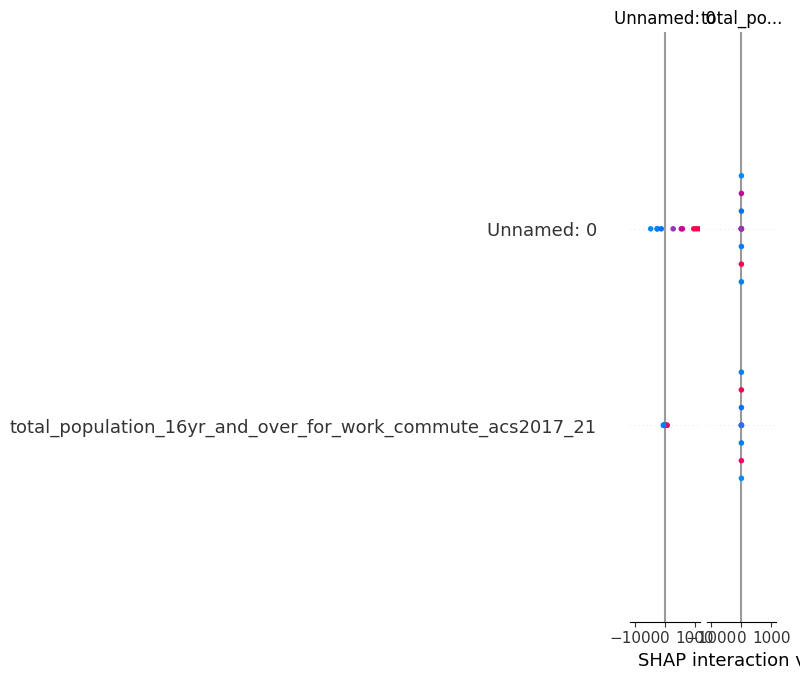

In [19]:
shap.summary_plot(shap_values, X_test_subset, feature_names=X_train.columns)